In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from scipy.constants import pi, c
from scipy.signal import hilbert, find_peaks
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [2]:
plt.rcParams['figure.figsize'] = [10,5]

In [3]:
#Define conversion functions/factors to get to/from meep units and kms
#Length factor to transform lengths in kms
l_unit = 1e-6 #1 um
t_unit = l_unit/c #time unit is length/c

#multiplicative constants to convert frequencies from meep to kms hertz
freq_unit = c/l_unit

print("1 meep Length unit is", l_unit*1e+6, "um")
print("1 meep Time unit is", t_unit*1e+15, "fs")
print("1 meep Frequency unit is", freq_unit*1e-12, "THz")

1 meep Length unit is 1.0 um
1 meep Time unit is 3.3356409519815204 fs
1 meep Frequency unit is 299.792458 THz


# Resolution

In [4]:
#courant factor
S = 0.5

#resolution is number of pixels per meep unit
resolution = 20

#resolutions in meep units
space_res = 1/resolution
time_res = space_res*S

print("Pixel per unit: ", resolution)

print("Space resolution [meep]: ", space_res)
print("Time resolution [meep]: ", time_res)

print("Space resolution [um]: ", space_res*l_unit*1e+6)
print("Time resolution [fs]: ", time_res*t_unit*1e+15)

time_freq = 1/time_res
print("Time sampling frequency [meep]: ", time_freq)
print("Nyqvist frequency [meep]: ", time_freq/2)

Pixel per unit:  20
Space resolution [meep]:  0.05
Time resolution [meep]:  0.025
Space resolution [um]:  0.049999999999999996
Time resolution [fs]:  0.08339102379953803
Time sampling frequency [meep]:  40.0
Nyqvist frequency [meep]:  20.0


# Geometry Definition
Cell

In [5]:
#define cell size and resolution
#Cell size is in meep units
#center is in (0,0), ranges in x=(-sx/2,sx/2), y=(-sy/2,sy/2)
sx = 80
sy = 26

cell = mp.Vector3(sx, sy)

#boundary conditions thickness
pml_thickness = 1.0

#automatic positioning of boundaries
x_bound_up = sx/2 - pml_thickness
x_bound_low = -sx/2 + pml_thickness

y_bound_up = sy/2 - pml_thickness
y_bound_low = -sy/2 + pml_thickness

In [6]:
#materials refractive indexes
n_bgnd = 1
n_wvg = 3.55
n_ring = n_wvg

#Separating distance
d = 0.10

#Width properties
wvg_width = 1.6

ring_r = 7
ring_w = wvg_width

#Position properties
wvg_x = 0
wvg_y = -(wvg_width + d + ring_w*2 + ring_r*2)/2 + wvg_width/2

ring_x = 0
ring_y = wvg_y + wvg_width/2 + d + ring_w + ring_r


In [7]:
fund_resonance = 1/(2*pi*(ring_r+ring_w/2)*n_ring)
print("Predicted fundamental resonance at: ", fund_resonance)

Predicted fundamental resonance at:  0.005747740812275022


In [8]:
#calculate frequency regions for single-mode confined excitations
from math import ceil


NA = np.sqrt(n_wvg*n_wvg - n_bgnd*n_bgnd)
cut_off_freq = 1/(2*d)

upper_bound_freq = ceil(cut_off_freq/NA)

print("Predicted numerical aperture ", upper_bound_freq)
print("Predicted cut-off frequency: ", cut_off_freq)
print("Predicted upper frequency: ", upper_bound_freq)

Predicted numerical aperture  2
Predicted cut-off frequency:  5.0
Predicted upper frequency:  2


Source

In [9]:
#Soure parameters
source_x = x_bound_low + 1
source_y = wvg_y

source_width = wvg_width

#Resonance number
m = 8

#note: df is not really the frequency sigma
f_central = fund_resonance*m
df = f_central/2

f_harm = f_central
df_harm = f_harm

print("#Source pulse frequency: fcent= ", f_central, " m.u., df= ",df, " m.u." )
print("#Source pulse frequency: fcent= ", f_central*freq_unit*1e-12, " THz, df= ",df*freq_unit*1e-12, " THz" )
print("#Source vacuum wavelength: lambda = ",  c/(f_central*freq_unit)*1e+6, "um, dlambda = ",c/(df*freq_unit)*1e+6,"um")
print("#Source wvg wavelength: lambda = ",  (c/n_wvg)/(f_central*freq_unit)*1e+6, "um")
print("#Source ring wavelength: lambda = ",  (c/n_ring)/(f_central*freq_unit)*1e+6, "um")

#Source pulse frequency: fcent=  0.045981926498200175  m.u., df=  0.022990963249100087  m.u.
#Source pulse frequency: fcent=  13.785034768470764  THz, df=  6.892517384235382  THz
#Source vacuum wavelength: lambda =  21.74767514447534 um, dlambda =  43.49535028895068 um
#Source wvg wavelength: lambda =  6.126105674500097 um
#Source ring wavelength: lambda =  6.126105674500097 um


Monitors

In [10]:

#Monitor parameters
#input
mon_1_x = source_x + 0.5
mon_1_y = wvg_y
mon_1_width = wvg_width

#output
mon_2_x = x_bound_up - 1
mon_2_y = wvg_y
mon_2_width = wvg_width

#number of sampling points in frequency for fourier transform of fields accumulated
N_freq = 300

#central frequency
f_mon_central = f_central
#width of sampled frequency band
df_mon = df


#Point for simulation termination condition
check_pt = mp.Vector3(mon_2_x - 0.1, mon_2_y)
check_pt_2 = mp.Vector3(ring_x, ring_y + ring_r + ring_w/2)
check_pt_3 = mp.Vector3(ring_x, ring_y - ring_r - ring_w/2)


# Harminv
Seek resonant frequencies

In [11]:
har_theta = pi/4
har_pt = mp.Vector3(ring_x + (ring_r + ring_w/2)*np.cos(har_theta), ring_y + (ring_r + ring_w/2)*np.sin(har_theta))

-----------
Initializing structure...
Halving computational cell along direction x
time for choose_chunkdivision = 0.000989914 s
Working in 2D dimensions.
Computational cell is 80 x 26 x 0 with resolution 20
     cylinder, center = (0,0.85,0)
          radius 8.6, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.6025,12.6025,12.6025)
     cylinder, center = (0,0.85,0)
          radius 7, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.705378 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

Meep progress: 29.675/200.0 = 14.8% done in 4.0s, 23.0s to go
on time step 1189 (time=29.725), 0.00336638 s/step
Meep progress: 58.275000000000006/200.0 = 29.1% done in 8.0s, 19.5s to go
on time step 2334 (time=58.35), 0.00349549 s/step
Meep progress: 87.30000000000001/200.0 = 43.7% done in 12.0s, 15.5s to go
on time step 3495 (time=87.375), 0.00344572 s/step
Meep progress: 116.85000000000001/200.0 = 58.4% done in 16.0s, 11.4s to go
on time step 4678 (time=116.95), 0.00338372 s/step
Meep progress: 148.07500000000002/200.0 = 74.0% done in 20.0s, 7.0s to go
on time step 5927 (time=148.175), 0.00320316 s/step
Meep progress: 179.425/200.0 = 89.7% done in 24.0s, 2.8s to go
on time step 7181 (time=179.525), 0.00319215 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
run 0 finished at t = 200.0 (8000 timesteps)


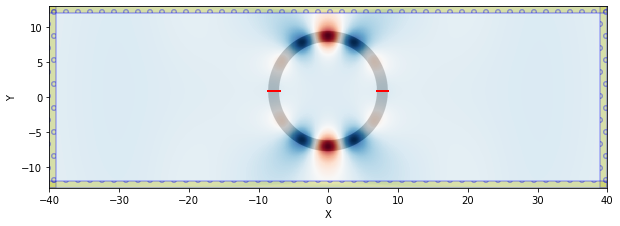

In [12]:
#Geometry objects
ext_ring = mp.Cylinder(radius=ring_r+ring_w,
                    center=mp.Vector3(ring_x, ring_y),
                    material = mp.Medium(index=n_ring))
int_ring = mp.Cylinder(radius=ring_r,
                    center=mp.Vector3(ring_x, ring_y))

geometry = [ext_ring,
            int_ring]

#define sources
#gaussian pulse with f_central and df
sources = [mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*3),
                     component=mp.Ez,
                     center=mp.Vector3(ring_x + ring_r + ring_w/2, ring_y),
                     size=mp.Vector3(ring_w, 0)),

                     mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*3),
                     component=mp.Ez,
                     center=mp.Vector3(-(ring_x + ring_r + ring_w/2), ring_y),
                     size=mp.Vector3(ring_w, 0))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]

#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,
                    resolution=resolution,
                    symmetries=[mp.Mirror(mp.X)])
"""
animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})
"""
har = mp.Harminv(mp.Ez, har_pt, f_mon_central, df_mon)

#Simulate
mp.verbosity(1)
sim.run( mp.after_sources(har), until=200)
#mp.at_every(1,animate),
#animate.to_mp4(10, "Ez_Harminv.mp4")

sim.plot2D(fields=mp.Ez,
           field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'none'},
           boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})
plt.show()

In [13]:
#Video("Ez_Harminv.mp4")

In [14]:
har_freq = [m.freq for m in har.modes]
print(har_freq)

[]


# Normalization run

In [15]:
sim.reset_meep()
#Geometry objects
waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                    center = mp.Vector3(wvg_x, wvg_y),
                    material = mp.Medium(index=n_wvg))

geometry = [waveguide]

#define sources
#gaussian pulse with f_central and df
sources = [mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*3),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]

#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,
                    resolution=resolution)

# Flux Monitor 1
incident_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, mon_1_y), size=mp.Vector3(0, mon_1_width, 0))
incident = sim.add_flux(f_mon_central, df_mon, N_freq, incident_fr)

# Flux Monitor 2
tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, mon_2_y), size=mp.Vector3(0,mon_2_width,0))
tran = sim.add_flux(f_mon_central, df_mon, N_freq, tran_fr)

#Simulate
mp.verbosity(1)
sim.run( until_after_sources = mp.stop_when_fields_decayed(100, mp.Ez, check_pt, 1e-3))


#Get Fourier-transformed fields of incident pulse
norm_incident_data = sim.get_flux_data(incident)

#Get fluxes from fourier transformed fields transmitted
norm_tran_flux = mp.get_fluxes(tran)

#Get fluxes from fourier transformed incident fields
norm_inc_flux = mp.get_fluxes(incident)

flux_freqs = mp.get_flux_freqs(tran)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 2D dimensions.
Computational cell is 80 x 26 x 0 with resolution 20
     block, center = (0,-8.65,0)
          size (1e+20,1.6,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.6025,12.6025,12.6025)
time for set_epsilon = 1.01372 s
-----------
on time step 553 (time=13.825), 0.00723721 s/step
on time step 1116 (time=27.9), 0.00711026 s/step
on time step 1677 (time=41.925), 0.00713465 s/step
on time step 2240 (time=56), 0.00711463 s/step
on time step 2806 (time=70.15), 0.00707831 s/step
on time step 3379 (time=84.475), 0.00699043 s/step
on time step 3954 (time=98.85), 0.00696394 s/step
field decay(t = 100.025): 1.0677459222088825e-14 / 1.0677459222088825e-14 = 1.0
on time step 4527 (time=113.175), 0.00698775 s/step
on time step 5098 (time=127.45), 0.0070053 s/step
on time step 5670 (time=141.75), 0.00699409 s/step
on time step 6243 (time=156.0

# Broad run

In [16]:
sim.reset_meep()

In [17]:
#Geometry objects
waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                    center = mp.Vector3(wvg_x, wvg_y),
                    material = mp.Medium(index=n_wvg))
ext_ring = mp.Cylinder(radius=ring_r+ring_w,
                    center=mp.Vector3(ring_x, ring_y),
                    material = mp.Medium(index=n_ring))
int_ring = mp.Cylinder(radius=ring_r,
                    center=mp.Vector3(ring_x, ring_y))

geometry = [waveguide,
            ext_ring,
            int_ring]

#define sources
#gaussian pulse with f_central and df
sources = [mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*3),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]

#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,
                    resolution=resolution)

# Flux Monitor 1
incident_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, mon_1_y), size=mp.Vector3(0, mon_1_width, 0))
incident = sim.add_flux(f_mon_central, df_mon, N_freq, incident_fr)

# Flux Monitor 2
tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, mon_2_y), size=mp.Vector3(0,mon_2_width,0))
tran = sim.add_flux(f_mon_central, df_mon, N_freq, tran_fr)

"""
animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})
"""

#Simulate
mp.verbosity(1)
sim.run( until_after_sources = mp.stop_when_fields_decayed(100, mp.Ez, check_pt, 1e-3))

#mp.at_every(1,animate),
#animate.to_mp4(10, "Ez_norm.mp4")

-----------
Initializing structure...
time for choose_chunkdivision = 0.000324965 s
Working in 2D dimensions.
Computational cell is 80 x 26 x 0 with resolution 20
     block, center = (0,-8.65,0)
          size (1e+20,1.6,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.6025,12.6025,12.6025)
     cylinder, center = (0,0.85,0)
          radius 8.6, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.6025,12.6025,12.6025)
     cylinder, center = (0,0.85,0)
          radius 7, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 1.46559 s
-----------
on time step 550 (time=13.75), 0.00727878 s/step
on time step 1115 (time=27.875), 0.00708255 s/step
on time step 1683 (time=42.075), 0.00705233 s/step
on time step 2251 (time=56.275), 0.00704374 s/step
on time step 2811 (time=70.275), 0.0071549 s/step
on time step 3380 (time=84.5), 0.00704024 s/step
on time

In [18]:
#Video("Ez_norm.mp4")

In [19]:

#Get Fourier-transformed fields of incident pulse
ring_incident_data = sim.get_flux_data(incident)

#Get fluxes from fourier transformed fields transmitted
ring_tran_flux = mp.get_fluxes(tran)

#Get fluxes from fourier transformed incident fields
ring_inc_flux = mp.get_fluxes(incident)

ring_freqs = mp.get_flux_freqs(tran)

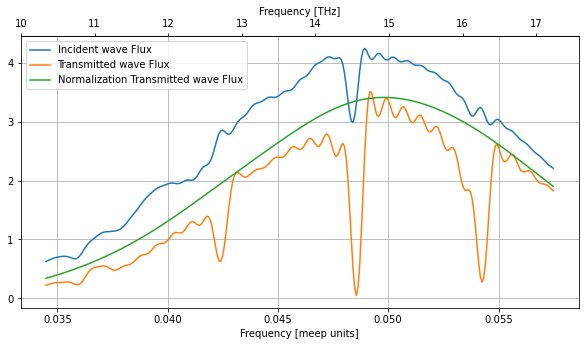

In [20]:
plt.plot(flux_freqs, ring_inc_flux, label="Incident wave Flux")
plt.plot(flux_freqs, ring_tran_flux, label="Transmitted wave Flux")
plt.plot(flux_freqs, norm_tran_flux, label="Normalization Transmitted wave Flux")

plt.xlabel("Frequency [meep units]")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')


for xc in har_freq:
    plt.axvline(x=xc)

plt.legend()
plt.grid()

In [21]:
Tr = np.array(ring_tran_flux)/np.array(norm_tran_flux)

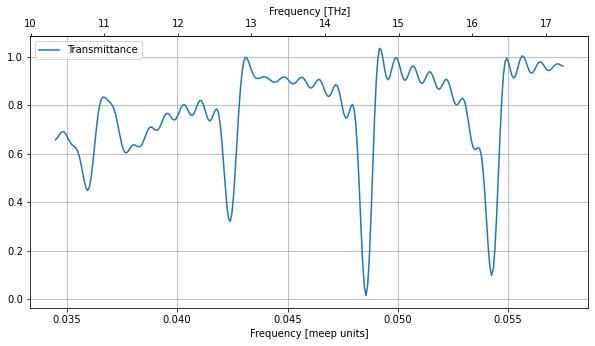

In [22]:
plt.plot(flux_freqs, Tr, label="Transmittance")

plt.xlabel("Frequency [meep units]")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')


for xc in har_freq:
    plt.axvline(x=xc)

plt.legend()
plt.grid()

In [23]:
sim.reset_meep()

# Focused simulation

In [24]:
#Resonance values
f_central_resonance = fund_resonance*m
df_resonance = 0.01

#central frequency
f_mon_central_resonance = f_central_resonance
#width of sampled frequency band
df_mon_resonance = df_resonance

#predicted wavelength
pred_wvlght = 1/(f_central_resonance*n_ring)

print("Predicted wavelength: ",pred_wvlght)

Predicted wavelength:  6.126105674500097


In [25]:
#Geometry objects
waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                    center = mp.Vector3(wvg_x, wvg_y),
                    material = mp.Medium(index=n_wvg))
ext_ring = mp.Cylinder(radius=ring_r+ring_w,
                    center=mp.Vector3(ring_x, ring_y),
                    material = mp.Medium(index=n_ring))
int_ring = mp.Cylinder(radius=ring_r,
                    center=mp.Vector3(ring_x, ring_y))

geometry = [waveguide,
            ext_ring,
            int_ring]

#define sources
#gaussian pulse with f_central and df
sources = [mp.Source(mp.GaussianSource(frequency=f_central_resonance, fwidth=df_resonance*3),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]

#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,
                    resolution=resolution)

# Flux Monitor 1
incident_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, mon_1_y), size=mp.Vector3(0, mon_1_width, 0))
incident = sim.add_flux(f_mon_central_resonance, df_mon_resonance, N_freq, incident_fr)

# Flux Monitor 2
tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, mon_2_y), size=mp.Vector3(0,mon_2_width,0))
tran = sim.add_flux(f_mon_central_resonance, df_mon_resonance, N_freq, tran_fr)

"""
animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})
"""

#Simulate
mp.verbosity(0)
sim.run( until_after_sources = mp.stop_when_fields_decayed(200, mp.Ez, check_pt, 1e-3))
#mp.at_every(1,animate),

#animate.to_mp4(10, "Ez_norm.mp4")

In [26]:
#Video("Ez_norm.mp4")

In [27]:

#Get Fourier-transformed fields of incident pulse
norm_incident_data = sim.get_flux_data(incident)

#Get fluxes from fourier transformed fields transmitted
norm_tran_flux = mp.get_fluxes(tran)

#Get fluxes from fourier transformed incident fields
norm_inc_flux = mp.get_fluxes(incident)

flux_freqs = mp.get_flux_freqs(tran)

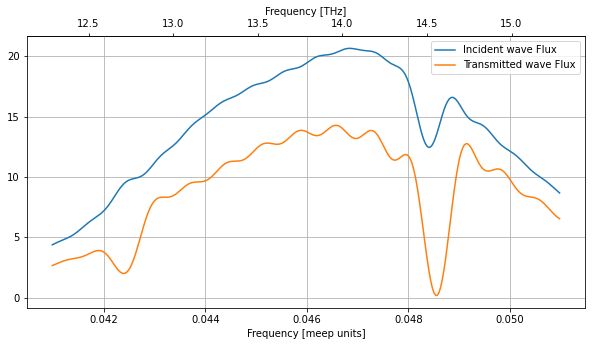

In [28]:
plt.plot(flux_freqs, norm_inc_flux, label="Incident wave Flux")
plt.plot(flux_freqs, norm_tran_flux, label="Transmitted wave Flux")

plt.xlabel("Frequency [meep units]")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')


plt.legend()
plt.grid()

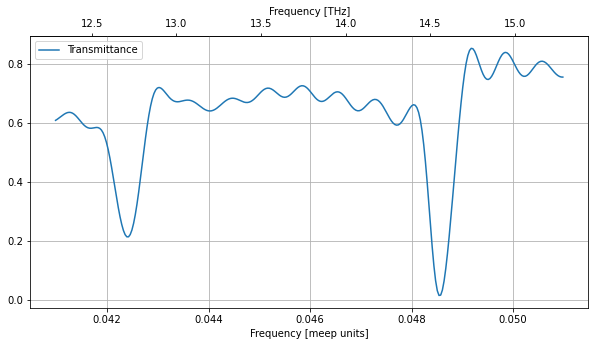

In [29]:
Tr = np.array(norm_tran_flux)/np.array(norm_inc_flux)

plt.plot(flux_freqs, Tr, label="Transmittance")

plt.xlabel("Frequency [meep units]")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')



plt.legend()
plt.grid()

In [30]:
freq_res_main = flux_freqs[np.argmin(Tr)]
print("Resonance freqeuency: ", freq_res_main )


Resonance freqeuency:  0.048540454926293816


# $\Delta \phi$ calculation

In [31]:
sim.reset_meep()

In [32]:
run_time = 550

In [33]:
#Geometry objects
waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                    center = mp.Vector3(wvg_x, wvg_y),
                    material = mp.Medium(index=n_wvg))
ext_ring = mp.Cylinder(radius=ring_r+ring_w,
                    center=mp.Vector3(ring_x, ring_y),
                    material = mp.Medium(index=n_ring))
int_ring = mp.Cylinder(radius=ring_r,
                    center=mp.Vector3(ring_x, ring_y))

geometry = [waveguide,
            ext_ring,
            int_ring]

#define sources
#gaussian pulse with f_central and df
sources = [mp.Source(mp.ContinuousSource(frequency=freq_res_main, width=100),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]

#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,
                    resolution=resolution)


# Flux Monitor 2
tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, mon_2_y), size=mp.Vector3(0,mon_2_width,0))
tran = sim.add_flux(freq_res_main, df_mon, N_freq, tran_fr)
  
"""
animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})
"""

#Simulate
mp.verbosity(0)
sim.run( until=run_time)
#mp.at_every(1,animate),
#animate.to_mp4(10, "Ez_norm.mp4")

FloatProgress(value=0.0, description='0% done ', max=550.0)

In [34]:
#Video("Ez_norm.mp4")

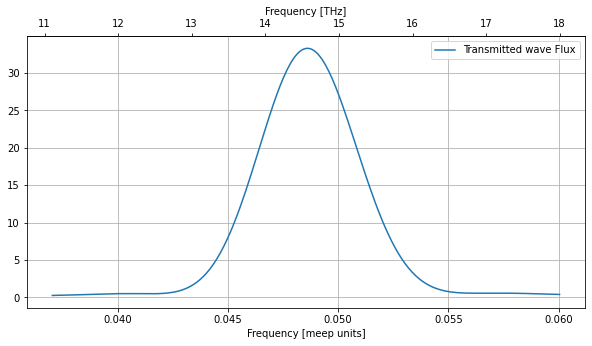

In [35]:
#Get fluxes from fourier transformed fields transmitted
norm_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(tran)

plt.plot(flux_freqs, norm_tran_flux, label="Transmitted wave Flux")

plt.xlabel("Frequency [meep units]")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')


plt.legend()
plt.grid()

In [36]:
ez_data_wvg = sim.get_array(center=mp.Vector3(0,wvg_y), size=mp.Vector3(sx, 0.001), component=mp.Ez)
print(ez_data_wvg.shape)

x = np.arange(-sx/2, sx/2, 1/resolution)

(1600, 2)


No handles with labels found to put in legend.


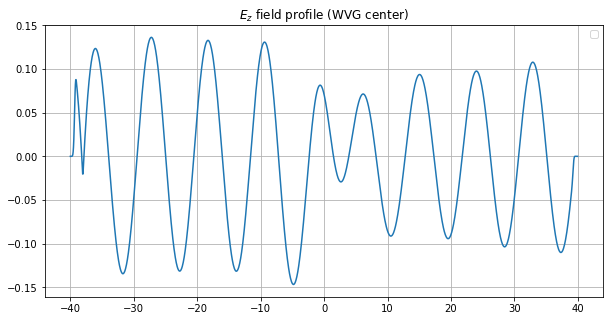

In [37]:
plt.figure()

plt.plot(x, ez_data_wvg[:,0])

plt.title(r"$E_z$ field profile (WVG center)")
plt.legend()
plt.grid()

## $\Delta \phi$ extraction

In [38]:
init_mask = (x>(source_x + 0.4))&(x<((-1)*(ring_r+ring_w)))

init_wave = ez_data_wvg[init_mask][:,0]
init_x = x[init_mask]

fin_mask = (x>(ring_r+ring_w))&(x<(x_bound_up-0.4))

fin_wave = ez_data_wvg[fin_mask][:,0]
fin_x = x[fin_mask]

wv_lngth = 1/(f_central_resonance*n_wvg)
wv_vector = 2*pi/(wv_lngth)


In [39]:
init_peaks, _ = find_peaks(init_wave, height=0.0)
fin_peaks, _ = find_peaks(fin_wave, height=0.0)

init_x_peaks = init_x[init_peaks]
fin_x_peaks = fin_x[fin_peaks]

init_spacings = np.diff(init_x[init_peaks])
fin_spacings = np.diff(fin_x[fin_peaks])

print(init_spacings)
print(fin_spacings)

[8.8  8.95 8.9 ]
[8.95 8.9 ]


## Linear fit to extract wavelength

In [40]:
def func_linear(m, k, phi):
    return (m*2*pi + pi/2 -phi)/k

popt_init, pcov_init = curve_fit(func_linear, [i[0] for i in enumerate(init_x_peaks)], init_x_peaks)

k_fit_init = popt_init[0]
phi_init = popt_init[1]%(2*pi)

print("K_init: ",k_fit_init," phi_init:", phi_init)
print("wavelength_init: ",2*pi/k_fit_init)


popt_fin, pcov_fin = curve_fit(func_linear, [i[0] for i in enumerate(fin_x_peaks)], fin_x_peaks)

k_fit_fin = popt_fin[0]
phi_fin = popt_fin[1]%(2*pi)

print("K_fin: ",k_fit_fin," phi_fin:", phi_fin)
print("wavelength_fin: ",2*pi/k_fit_fin)


DeltaPhi = (phi_fin - phi_init)%(2*pi)
print("Delta Phi:", DeltaPhi, "Pis:",DeltaPhi/pi, ", Degrees: ",DeltaPhi*360/(2*pi))


K_init:  0.7067700007869727  phi_init: 1.9418505767970622
wavelength_init:  8.890000000259489
K_fin:  0.7039983537494219  phi_fin: 3.5361250642091484
wavelength_fin:  8.924999999951698
Delta Phi: 1.5942744874120862 Pis: 0.5074733306338624 , Degrees:  91.34519951409524


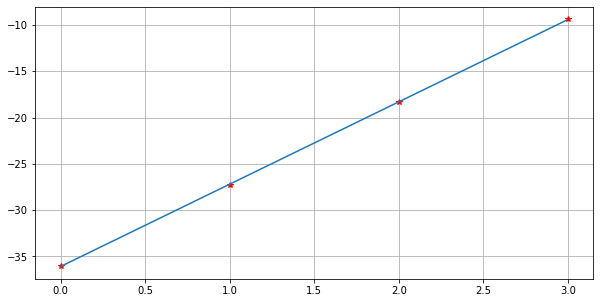

In [41]:
dummy_m_init = np.arange(np.amin([i[0] for i in enumerate(init_x_peaks)]), np.amax([i[0] for i in enumerate(init_x_peaks)]), 0.01)

plt.plot([i[0] for i in enumerate(init_x_peaks)],init_x_peaks ,"r*")
plt.plot(dummy_m_init, func_linear(dummy_m_init, *popt_init), label=r"linear fit")

plt.grid()

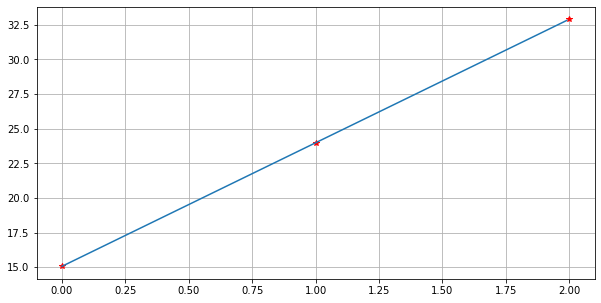

In [42]:
dummy_m_fin = np.arange(np.amin([i[0] for i in enumerate(fin_x_peaks)]), np.amax([i[0] for i in enumerate(fin_x_peaks)]), 0.01)

plt.plot([i[0] for i in enumerate(fin_x_peaks)],fin_x_peaks,"r*" )
plt.plot(dummy_m_fin, func_linear(dummy_m_fin, *popt_fin), label=r"linear fit")

plt.grid()

In [43]:
def func_1(x, k, phi):
    return np.amax(init_wave)*np.sin(k*x + phi)

def func_2(x, k, phi):
    return np.amax(fin_wave)*np.sin(k*x + phi)

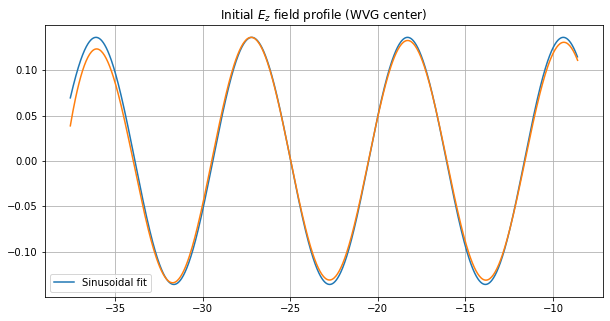

In [44]:
plt.figure()

dummy_x_init = np.arange(np.amin(init_x), np.amax(init_x), 0.01)

plt.plot(dummy_x_init, func_1(dummy_x_init, *popt_init), label=r"Sinusoidal fit")
plt.plot(init_x, init_wave)

plt.title(r"Initial $E_z$ field profile (WVG center)")
plt.legend()
plt.grid()

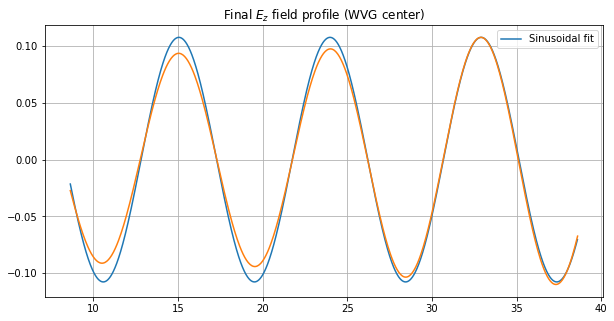

In [45]:
plt.figure()

dummy_x_fin = np.arange(np.amin(fin_x), np.amax(fin_x), 0.01)

plt.plot(dummy_x_fin, func_2(dummy_x_fin, *popt_fin), label=r"Sinusoidal fit")
plt.plot(fin_x, fin_wave)

plt.title(r"Final $E_z$ field profile (WVG center)")
plt.legend()
plt.grid()

In [46]:
## Sinusoidal fit, not very accurate
def func_1(x, k, phi):
    return np.amax(init_wave)*np.sin(k*x + phi)

def func_2(x, k, phi):
    return np.amax(fin_wave)*np.sin(k*x + phi)

popt_init_sine, pcov_init_sine = curve_fit(func_1, init_x, init_wave, p0=[wv_vector,0])
popt_fin_sine, pcov_fin_sine = curve_fit(func_2, fin_x, fin_wave,p0=[wv_vector,0])

print(popt_init_sine)
print(popt_fin_sine)

[ 1.01119405 -0.43025571]
[0.99152624 0.00689858]


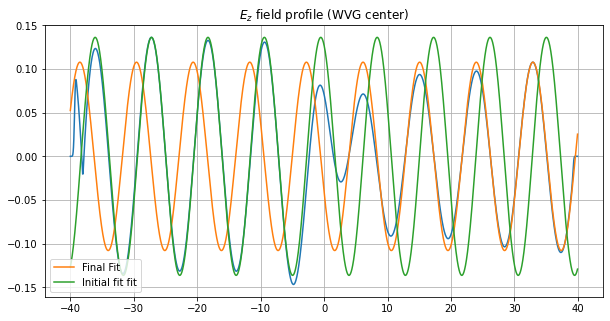

In [47]:
plt.figure()

dummy_x = np.arange(np.amin(x), np.amax(x), 0.01)

plt.plot(x, ez_data_wvg[:,0])
plt.plot(dummy_x, func_2(dummy_x, *popt_fin), label=r"Final Fit")
plt.plot(dummy_x, func_1(dummy_x, *popt_init), label=r"Initial fit fit")


plt.title(r"$E_z$ field profile (WVG center)")
plt.legend()
plt.grid()

# Notes

## Notch attenuation
## Resolution 20
0.05 0.2

0.1 0.3

0.2 0.7

0.3 0.8

0.5 0.9

0.6 0.96

## Resolution 40
0.05 0.2

# Resonances
d, f, Dphi

0.05, 0.14025, 0.1359pi

0.3, 0.14065, 0.135964pi

Ok so we are in undercoupling probably, and thhis is why we get values only around 0 (i think)
resonances until now: 0.14, 0.1298